# Tutorial 8 - EM Algorithm

## Problem 1: EM for Binary Asymmetric Channel

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Create Dataset
num_samples = 10_000
pX = np.array([0.2, 0.8]) 
p1 = 0.1 # Crossover probability
p2 = 0.4  # Crossover probability
em_iter = 100

In [9]:
# Transmitted symbols
X_samples = (np.random.rand(num_samples) > pX[0])
print(f'Mean of X: {np.mean(X_samples):.3f}')

Mean of X: 0.797


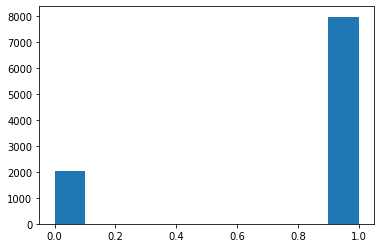

In [10]:
# Visualize distribution of the transmitted data
plt.hist(X_samples.astype(int), bins=10)
plt.show()

#### Simulate a binary asymmetric channel

In [11]:
# Indices 
idx_X0 = X_samples == 0  # Indices of X=0
num_X0 = np.sum(idx_X0)  # Count the number of 0s
idx_X1 = np.invert(idx_X0)  # Indices of X=1
num_X1 = num_samples - num_X0  # Count the number of 1s

# Received symbols
Y_samples = (np.random.rand(num_samples))
Z = (np.random.rand(num_X0) <= p1)
print(f'Mean of Z for positions X=0: {np.mean(Z)}')
Y_samples[idx_X0] = np.logical_xor(X_samples[idx_X0], Z)

Z = (np.random.rand(num_X1) <= p2)
print(f'Mean of Z for positions X=1: {np.mean(Z)}')
Y_samples[idx_X1] = np.logical_xor(X_samples[idx_X1], Z)

Mean of Z for positions X=0: 0.11012345679012346
Mean of Z for positions X=1: 0.39924764890282133


#### If we know form which X was transmitted each y_i it is easy to estimate p1, p2 (aka supervised setting)

In [12]:
print(f'Estimate of p1: {np.mean(Y_samples[idx_X0])}')
print(f'Estimate of p2: {np.mean(Y_samples[idx_X1])}')

Estimate of p1: 0.11012345679012346
Estimate of p2: 0.6007523510971787


In [13]:
# Function that calculates qxi for the E-step
def calc_qxi(y, th):
    qxi = np.zeros((y.size, 2))
    
    for i in range(y.size):
        tmp0 = pX[0] * th[0] ** y[i] * (1-th[0]) ** (1-y[i])
        tmp1 = pX[1] * th[1] ** (1-y[i]) * (1-th[1]) ** (y[i])
        qxi[i,0] = tmp0 / (tmp0 + tmp1)
        qxi[i,1] = tmp1 / (tmp0 + tmp1)
    
    return qxi

#### Initialize and run the EM algorithm

In [15]:
# Initialization
theta = np.array([0.5, 0.5])
print(f"Initialization: p1 = {theta[0]:.3f} and p2 = {theta[1]:.3f}\n")

ys = Y_samples.astype(float)

for i in range(em_iter):
    ## E-Step
    qxi = calc_qxi(ys, theta)

    ## M-Step
    theta[0] = np.sum(qxi[:,0] * ys) / np.sum(qxi[:,0])
    theta[1] = np.sum(qxi[:,1] * (1-ys)) / np.sum(qxi[:,1])  
    if i % 10 == 0 :
        print(f"Iteration {i}, Estimate: p1 = {theta[0]:.3f} and p2 = {theta[1]:.3f}")

Initialization: p1 = 0.500 and p2 = 0.500

Iteration 0, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 10, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 20, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 30, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 40, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 50, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 60, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 70, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 80, Estimate: p1 = 0.501 and p2 = 0.499
Iteration 90, Estimate: p1 = 0.501 and p2 = 0.499


## ASK 

In [17]:
import scipy.stats

**Compute the distribution $p_Y$ of $Y$ for given $X$, $p_X$, and $\sigma^2$** 

In [18]:
def awgn_pY(y, X, pX, sigma2):
    # reshape X as row-vector and y as column-vector for broadcasting
    X = X.reshape((1, X.size))
    pX = pX.reshape((1, pX.size))
    y = y.reshape((y.size, 1))

    # calculate pY
    pY = np.sum( pX * scipy.stats.norm.pdf(y, X, np.sqrt(sigma2)), axis=1 )
    return pY    

**Implement the EM Algorithm**

In [19]:
def em(y, X_init, pX_init, sigma2_init, delta_init, num_iter):
    """
    Implements the expectation maximization algorithm for 
    a Gaussian mixture model. y should be a numpy vector
    containing the observed samples. The variables X_init,
    pX_init, sigma2_init, and delta_init represent the initial
    start values for the constellations points, their probability
    distribution, the noise variance, and the constellation
    scaling factor delta, respectively.
    'num_iter' defines the number of iterations.

    A dictionary is returned with the fields 'x', 'px'
    and 'sigma2'.
    """
    
    N = y.size # number of samples
    M = X_init.size # cardinality of constellation
    
    # reshape and rename inputs (y as column vector, X as row vector)
    y = y.reshape((N,1))
    X = X_init.reshape((1,M))
    pX = pX_init.reshape((1,M))
    sigma2 = sigma2_init
    delta = delta_init

    
    for it in range(num_iter):
        #print("iter {}".format(it))
        
        ## E-Step: Calculate auxiliary distribution Q_{X|Y}
        ##   for all samples y_i, i=1,...,N
        ##   with current estimates for X, pX, and sigma2
        tmp = pX * scipy.stats.norm.pdf(y, X, np.sqrt(sigma2)) # shape (N,M)
        Q_xy = tmp / np.sum( tmp, axis=1 ).reshape(-1,1) # sum is shape (1,N)
        
        ## M-Step: Optimize parameters X, pX, sigma2
        ##     for fixed aux. distribution Q_{X|Y}
        pX = np.sum(Q_xy, axis=0) / N

        delta = np.sum( np.sum( Q_xy * (X/delta) * y ) ) / np.sum( np.sum( Q_xy * (X/delta)**2 ) )
        X = delta * np.arange(-M+1, M+1, 2)

        sigma2 = np.sum( np.sum( Q_xy * (y-X)**2 )) / N

        
        ## Debug output
        if it % 1 == 0:
            print("it {:d}: delta={:.2f}, sigma2={:.2f}, X=[".format(it, delta, sigma2), end='')
            for ii in range(M):
                print("{:.1f} ".format(X[ii]), end='')
            print("], pX=[", end='')
            for ii in range(M):
                print("{:.2f} ".format(pX[ii]), end='')
            print("]")
    
    data = {'X': X, 'pX': pX, 'sigma2': sigma2, 'delta': delta}
    return data    

**Define the system parameters and create samples**

In [20]:
M = 8
N = 10000
delta = 1
SNRdB = 15
SNR = 10**(SNRdB/10)

X = np.arange(-M+1, M+1, 2)
nu = 0.0641 # chosen to get a distribution with a selected entropy of 2.5
pX = np.exp(-nu*X**2)
pX = pX/np.sum(pX)
#pX = np.ones(M)/M # uniform

# generate transmit symbol samples
x = np.random.choice(X, p=pX, size=N)

# calculate sigma**2
P = np.mean(x**2)
sigma2 = P/SNR

# simulate channel
y = delta * x + np.random.randn(N)*np.sqrt(sigma2)

In [25]:
sigma2

0.2331231091076129

**Plot the distribution $p_Y$ (ground truth)**

In [21]:
pX

array([0.01239659, 0.05773255, 0.1610027 , 0.26886816, 0.26886816,
       0.1610027 , 0.05773255, 0.01239659])

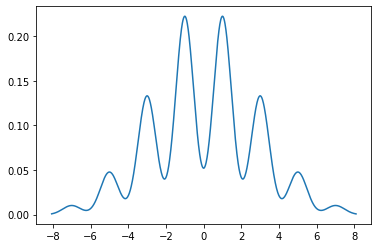

In [22]:
yrange = np.linspace(np.min(y), np.max(y), 1000)
py = awgn_pY(yrange, delta*X, pX, sigma2)
plt.plot(yrange, py)
plt.show()

**Define initialization values and run EM algorithm**

In [26]:
# run EM
X_init = np.linspace(np.min(y), np.max(y), M)
pX_init = np.ones(M)/M # uniform
sigma2_init = 1
delta_init = 1
num_iter = 20
params_out = em(y, X_init, pX_init, sigma2_init, delta_init, num_iter)
#print(params_out)

print("Sigma2: {:.3f}".format(params_out['sigma2']))
print("Delta: {:.3f}".format(params_out['delta']))
print("P_X: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*params_out['pX']))
print("X: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*params_out['X']))

it 0: delta=0.89, sigma2=0.93, X=[-6.2 -4.4 -2.7 -0.9 0.9 2.7 4.4 6.2 ], pX=[0.01 0.05 0.16 0.28 0.28 0.16 0.05 0.01 ]
it 1: delta=0.92, sigma2=0.93, X=[-6.5 -4.6 -2.8 -0.9 0.9 2.8 4.6 6.5 ], pX=[0.01 0.06 0.17 0.26 0.26 0.16 0.07 0.01 ]
it 2: delta=0.93, sigma2=0.88, X=[-6.5 -4.6 -2.8 -0.9 0.9 2.8 4.6 6.5 ], pX=[0.01 0.06 0.17 0.26 0.26 0.16 0.07 0.01 ]
it 3: delta=0.93, sigma2=0.83, X=[-6.5 -4.7 -2.8 -0.9 0.9 2.8 4.7 6.5 ], pX=[0.01 0.06 0.17 0.26 0.26 0.16 0.07 0.01 ]
it 4: delta=0.94, sigma2=0.76, X=[-6.6 -4.7 -2.8 -0.9 0.9 2.8 4.7 6.6 ], pX=[0.01 0.05 0.17 0.26 0.27 0.16 0.07 0.01 ]
it 5: delta=0.95, sigma2=0.69, X=[-6.6 -4.7 -2.8 -0.9 0.9 2.8 4.7 6.6 ], pX=[0.01 0.05 0.17 0.26 0.27 0.16 0.06 0.01 ]
it 6: delta=0.96, sigma2=0.61, X=[-6.7 -4.8 -2.9 -1.0 1.0 2.9 4.8 6.7 ], pX=[0.01 0.05 0.17 0.26 0.27 0.16 0.06 0.01 ]
it 7: delta=0.97, sigma2=0.51, X=[-6.8 -4.8 -2.9 -1.0 1.0 2.9 4.8 6.8 ], pX=[0.01 0.05 0.17 0.26 0.27 0.16 0.06 0.01 ]
it 8: delta=0.98, sigma2=0.41, X=[-6.9 -4.9 -2.9

**Plot the distribution $p_Y$ with the parameters estimated by the EM algorithm**

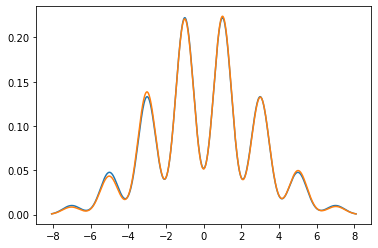

In [27]:
# plot
estim_py = awgn_pY(yrange,params_out['X'],params_out['pX'],params_out['sigma2'])
plt.plot(yrange, py, yrange, estim_py)
plt.show()

**We will now use the python library *scikit-learn* to run the EM algorithm**

see https://scikit-learn.org/

In [28]:
from sklearn.mixture import GaussianMixture

scikit-learn can run the EM algorithm for Gaussian mixture models using *sklearn.mixture.GaussianMixture*, see https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In this model, the inputs $X$ are called *means* and the probabilities $p_X$ of the inputs are called *weights*.

In [29]:
# Init parameters
means_init = np.linspace(np.min(y), np.max(y), M).reshape(M,1)
weights_init = np.ones(M)/M # uniform
sigma2_init = 1

# Run EM
gm = GaussianMixture(n_components=M,
                     covariance_type='tied',
                     n_init=1,
                     weights_init=weights_init,
                     means_init=means_init,
                     precisions_init=np.array([1/sigma2_init,]).reshape(1,1),
)
gm.fit(y.reshape(-1,1))

GaussianMixture(covariance_type='tied',
                means_init=array([[-8.06440558],
       [-5.75701757],
       [-3.44962957],
       [-1.14224156],
       [ 1.16514644],
       [ 3.47253444],
       [ 5.77992245],
       [ 8.08731045]]),
                n_components=8, precisions_init=array([[1.]]),
                weights_init=array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]))

In [30]:
print("Sigma2: {:.3f}".format(*gm.covariances_[0] ))
print("P_X: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*gm.weights_))
print("X: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*gm.means_.reshape(1,-1)[0]))

Sigma2: 0.235
P_X: 0.01, 0.05, 0.17, 0.27, 0.27, 0.16, 0.06, 0.01
X: -7.04, -5.01, -3.01, -1.00, 1.00, 3.02, 5.02, 6.95


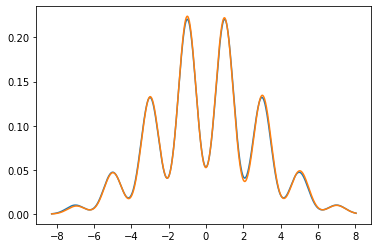

In [53]:
# plot
estim_py = awgn_pY(yrange,gm.means_,gm.weights_,gm.covariances_[0])
plt.plot(yrange, py, yrange, estim_py)
plt.show()

In [31]:
gm.n_iter_

10